## Calculate distance between means/medoids of mutation groupings

Our goal is to find an unsupervised way of calculating distance/similarity between our mutation groupings ("none"/"one"/"both") which isn't affected by sample size, to the degree that differentially expressed gene count was (see `4_de_analysis` notebooks).

Here, we'll try the extremely simple method of:

1) taking the n-dimensional mean (centroid) or median (medoid) of each group  
2) calculating distance between the centroids and using this to define "expression similarity"

We'll try this for a few different feature selection/embedding methods, and for both gene expression and RPPA (protein expression) data.

In [1]:
from pathlib import Path
import pickle as pkl
import itertools as it

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
import config as cfg

%load_ext autoreload
%autoreload 2

### Notebook parameters

These control which type of data to use, how to preprocess the data, how to calculate the centroid distances, etc.

Defaults are chosen mostly to make the script run quickly (expression data takes much longer to load and preprocess), although they seem to be somewhat representative of the overall results.

In [2]:
# whether to use expression or rppa data
data_type = 'rppa'

# how to calculate centroids, 'mean' or 'median'
centroid_method = 'median'

# preprocessing method, 'none' or 'pca' currently
preprocessing = 'pca'

# number of features to subset to
# for 'none' preprocessing this is the number of features by MAD
# (None = no subset by MAD)
# for 'pca' preprocessing this is the number of PCs to use
subset_feats = 50

# number of samples to require in each "hit" grouping, None = no minimum
min_sample_count = 15

### Load expression data

We'll also subset to the top features by mean absolute deviation, if `subset_feats` is set.

In [3]:
expression_data_file = (
    '/home/jake/research/mpmp/data/tcga_expression_matrix_processed.tsv.gz'
)

rppa_data_file = (
    '/home/jake/research/mpmp/data/tcga_rppa_matrix_processed.tsv'
)

if data_type == 'expression':
    data_df = pd.read_csv(expression_data_file, sep='\t', index_col=0)
elif data_type == 'rppa':
    data_df = pd.read_csv(rppa_data_file, sep='\t', index_col=0)
    
print(data_df.shape)
data_df.iloc[:5, :5]

(7790, 189)


,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46,X53BP1
sample_id,,,,,
TCGA-OR-A5J2-01,-0.494,0.592,0.10500,-0.13500,1.89
TCGA-PA-A5YG-01,-0.535,0.183,-0.10600,-0.04010,1.03
TCGA-OR-A5JV-01,-0.109,0.418,0.02470,-0.72100,1.66
TCGA-OR-A5JT-01,-0.413,0.259,0.00597,0.56300,1.46
TCGA-OR-A5JR-01,-0.288,-0.112,0.01940,-0.00267,2.23


In [4]:
# if PCA preprocessing is selected, convert raw features to PCs
# select the number of PCs using subset_feats
if preprocessing == 'pca':
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # standardize features first
    data_df = pd.DataFrame(
        StandardScaler().fit_transform(data_df),
        index=data_df.index.copy(),
        columns=data_df.columns.copy()
    )
    
    # then transform using PCA
    pca = PCA(n_components=subset_feats)
    data_df = pd.DataFrame(
        pca.fit_transform(data_df),
        index=data_df.index.copy(),
        columns=['PC{}'.format(i) for i in range(subset_feats)]
    )
    
data_df.iloc[:5, :5]

,PC0,PC1,PC2,PC3,PC4
sample_id,,,,,
TCGA-OR-A5J2-01,2.482787,-1.427503,6.162653,-3.184009,-0.849686
TCGA-PA-A5YG-01,4.580258,-2.363782,4.349306,-6.738443,-6.499179
TCGA-OR-A5JV-01,3.655522,-0.904992,7.636238,-5.595649,-0.933572
TCGA-OR-A5JT-01,6.167191,-1.698450,3.017662,-1.716091,-3.258655
TCGA-OR-A5JR-01,3.105162,2.714201,4.817767,-4.984164,-2.777633


In [5]:
# if no preprocessing, subset features by mean absolute deviation
if preprocessing == 'none' and subset_feats is not None:
    mad_ranking = (
        data_df.mad(axis=0)
               .sort_values(ascending=False)
    )
    top_feats = mad_ranking[:subset_feats].index.astype(str).values
    print(top_feats[:5])
    data_df = data_df.reindex(top_feats, axis='columns')
    
print(data_df.shape)
data_df.iloc[:5, :5]

(7790, 50)


,PC0,PC1,PC2,PC3,PC4
sample_id,,,,,
TCGA-OR-A5J2-01,2.482787,-1.427503,6.162653,-3.184009,-0.849686
TCGA-PA-A5YG-01,4.580258,-2.363782,4.349306,-6.738443,-6.499179
TCGA-OR-A5JV-01,3.655522,-0.904992,7.636238,-5.595649,-0.933572
TCGA-OR-A5JT-01,6.167191,-1.698450,3.017662,-1.716091,-3.258655
TCGA-OR-A5JR-01,3.105162,2.714201,4.817767,-4.984164,-2.777633


### Load Park et al. "hit" data

This was collated/formatted in `0_process_park.ipynb`

In [6]:
with open(cfg.distance_gain_info, 'rb') as f:
    park_gain_info = pkl.load(f)
    
park_gain_info['TP53_BRCA'].head()

,class_name,mutation_status,cnv_status,num_hits
TCGA-3C-AAAU-01,class 4,0,1,one
TCGA-3C-AALI-01,class 4,1,1,both
TCGA-3C-AALJ-01,class 4,0,1,one
TCGA-3C-AALK-01,class 4,0,1,one
TCGA-4H-AAAK-01,class 4,0,1,one


In [7]:
with open(cfg.distance_loss_info, 'rb') as f:
    park_loss_info = pkl.load(f)
    
park_loss_info['TP53_BRCA'].head()

,class_name,mutation_status,cnv_status,num_hits
TCGA-3C-AAAU-01,class 4,0,0,none
TCGA-3C-AALI-01,class 4,1,0,one
TCGA-3C-AALJ-01,class 4,0,0,none
TCGA-3C-AALK-01,class 4,0,0,none
TCGA-4H-AAAK-01,class 4,0,0,none


### Calculate distance between means/medians for given gene + cancer type

In [8]:
from scipy.spatial.distance import pdist, squareform

def get_centroids_and_distance(identifier, info_df, centroid_method='mean'):
    
    groups = ['both', 'none', 'one']
    group_combinations = list(it.combinations(groups, 2))
    class_name = info_df['class_name'].values[0]
    
    # get (gene/protein) expression data for samples
    samples = info_df.index.intersection(data_df.index)
    info_df = info_df.reindex(samples)
    
    # if one group has no samples, we have to make sure to assign it 0 count
    class_counts = []
    hit_class_counts = info_df.groupby('num_hits').count().class_name
    for group in groups:
        if group in hit_class_counts.index:
            class_counts.append(hit_class_counts[group])
        else:
            class_counts.append(0)
    
    # group by number of hits, then calculate centroids
    centroids_df = (data_df
        .reindex(samples)
        .merge(info_df['num_hits'], left_index=True, right_index=True)
        .groupby('num_hits')
    )
    
    if centroid_method == 'mean':
        centroids_df = centroids_df.mean()
    elif centroid_method == 'median':
        centroids_df = centroids_df.median()
    else:
        raise NotImplementedError(
            'centroid method {} not implemented'.format(centroid_method)
        )
    
    # calculate distance between centroids
    # make sure this is in the same order for each identifier, and
    # handle NA distances here (if one group doesn't have any samples)
    dists = pdist(centroids_df.values, metric='euclidean')
    dist_combinations = list(it.combinations(hit_class_counts.index, 2))
    ordered_dists = []
    for cmb in group_combinations:
        if cmb not in dist_combinations:
            ordered_dists.append(np.nan)
        else:
            cmb_ix = dist_combinations.index(cmb)
            ordered_dists.append(dists[cmb_ix])
    
    return (groups,
            group_combinations,
            class_counts,
            ordered_dists)
    
get_centroids_and_distance('TP53_BRCA',
                           park_loss_info['TP53_BRCA'],
                           'median')

(['both', 'none', 'one'],
 [('both', 'none'), ('both', 'one'), ('none', 'one')],
 [19, 491, 287],
 [6.384140961602226, 3.606426316630009, 4.212145962084997])

### Calculate centroid distance between "hits", per class

Class 1 = look at both loss and gain (should be one-hit in neither)  
Class 2 = only look at loss (should be one-hit here)  
Class 3 = only look at gain (should be one-hit here)  
Class 4 = look at both loss and gain (should be one-hit in both)

In [9]:
class_counts_df = {}
results_df = {}
class_names = {}
counts_columns = None
results_columns = None

# get distances for copy loss, for class 1/2/4 genes
for identifier, loss_df in park_loss_info.items():
    
    class_name = loss_df.head(1).class_name.values[0]
    if class_name == 'class 3':
        continue
        
    results = get_centroids_and_distance(identifier, loss_df, 'mean')
    
    if counts_columns is None:
        counts_columns = results[0]
    else:
        assert counts_columns == results[0]
        
    if results_columns is None:
        results_columns = ['{}/{}'.format(i, j) for i, j in results[1]]
            
    class_names[identifier] = class_name
    class_counts_df[identifier] = results[2]
    results_df[identifier] = results[3]
    
class_counts_loss_df = (
    pd.DataFrame(class_counts_df.values(),
                 index=class_counts_df.keys(),
                 columns=counts_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
results_loss_df = (
    pd.DataFrame(results_df.values(),
                 index=results_df.keys(),
                 columns=results_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
print(class_counts_loss_df.shape)
class_counts_loss_df.head()

(433, 4)


,both,none,one,class_name
ACVR1_UCEC,2,309,94,class 1
ACVR2A_COADREAD,3,264,96,class 1
ACVR2A_LIHC,0,134,29,class 1
AJUBA_HNSC,5,132,65,class 2
AKT1_BRCA,5,650,142,class 1


In [10]:
if min_sample_count is not None:
    valid_rows = (class_counts_loss_df
        .drop(columns=['class_name'])
        .astype(int) 
        > min_sample_count
    ).all(axis=1)
    print('Valid rows:', valid_rows.sum(), '/', class_counts_loss_df.shape[0])
    valid_ids = class_counts_loss_df.index[valid_rows]
    valid_ids[:5]

Valid rows: 23 / 433


In [11]:
if min_sample_count is not None:
    results_loss_df = results_loss_df.loc[valid_ids, :]
    
print(results_loss_df.shape)
results_loss_df.head()

(23, 4)


,both/none,both/one,none/one,class_name
APC_COADREAD,2.383777,1.854543,2.630734,class 1
ARID1A_BLCA,2.488626,2.195538,1.786653,class 1
KMT2C_BLCA,3.412207,3.401809,1.209002,class 1
KMT2D_BLCA,1.837048,1.722636,1.442928,class 1
KMT2D_LUSC,1.911781,1.554032,1.398855,class 1


In [12]:
class_counts_df = {}
results_df = {}
class_names = {}
counts_columns = None
results_columns = None

# get distances for copy gain, for class 1/3/4 genes
for identifier, gain_df in park_gain_info.items():
    
    class_name = gain_df.head(1).class_name.values[0]
    if class_name == 'class 2':
        continue
        
    results = get_centroids_and_distance(identifier, gain_df, 'mean')
    
    if counts_columns is None:
        counts_columns = results[0]
    else:
        assert counts_columns == results[0]
        
    if results_columns is None:
        results_columns = ['{}/{}'.format(i, j) for i, j in results[1]]
            
    class_names[identifier] = class_name
    class_counts_df[identifier] = results[2]
    results_df[identifier] = results[3]
    
class_counts_gain_df = (
    pd.DataFrame(class_counts_df.values(),
                 index=class_counts_df.keys(),
                 columns=counts_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
results_gain_df = (
    pd.DataFrame(results_df.values(),
                 index=results_df.keys(),
                 columns=results_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
print(class_counts_gain_df.shape)
class_counts_gain_df.head()

(384, 4)


,both,none,one,class_name
ACVR1_UCEC,0,362,43,class 1
ACVR2A_COADREAD,2,320,41,class 1
ACVR2A_LIHC,2,133,28,class 1
AKT1_BRCA,0,557,240,class 1
AKT1_UCEC,0,347,58,class 1


In [13]:
if min_sample_count is not None:
    valid_rows = (class_counts_gain_df
        .drop(columns=['class_name'])
        .astype(int) 
        > min_sample_count
    ).all(axis=1)
    print('Valid rows:', valid_rows.sum(), '/', class_counts_gain_df.shape[0])
    valid_ids = class_counts_gain_df.index[valid_rows]
    valid_ids[:5]

Valid rows: 26 / 384


In [14]:
if min_sample_count is not None:
    results_gain_df = results_gain_df.loc[valid_ids, :]
    
print(results_gain_df.shape)
results_gain_df.head()

(26, 4)


,both/none,both/one,none/one,class_name
APC_COADREAD,2.950653,1.146716,2.656007,class 1
ARID1A_BLCA,2.799850,2.540046,1.100248,class 1
ATRX_LGG,2.658793,2.028181,1.857673,class 3
BAP1_KIRC,5.242828,3.414805,4.247451,class 1
CDKN2A_HNSC,3.418984,2.044129,2.132973,class 1


### Plot centroid distance results

To make our plots, we'll just get rid of NaN rows (i.e. genes/cancer types that don't have at least one sample in each "hit" category).

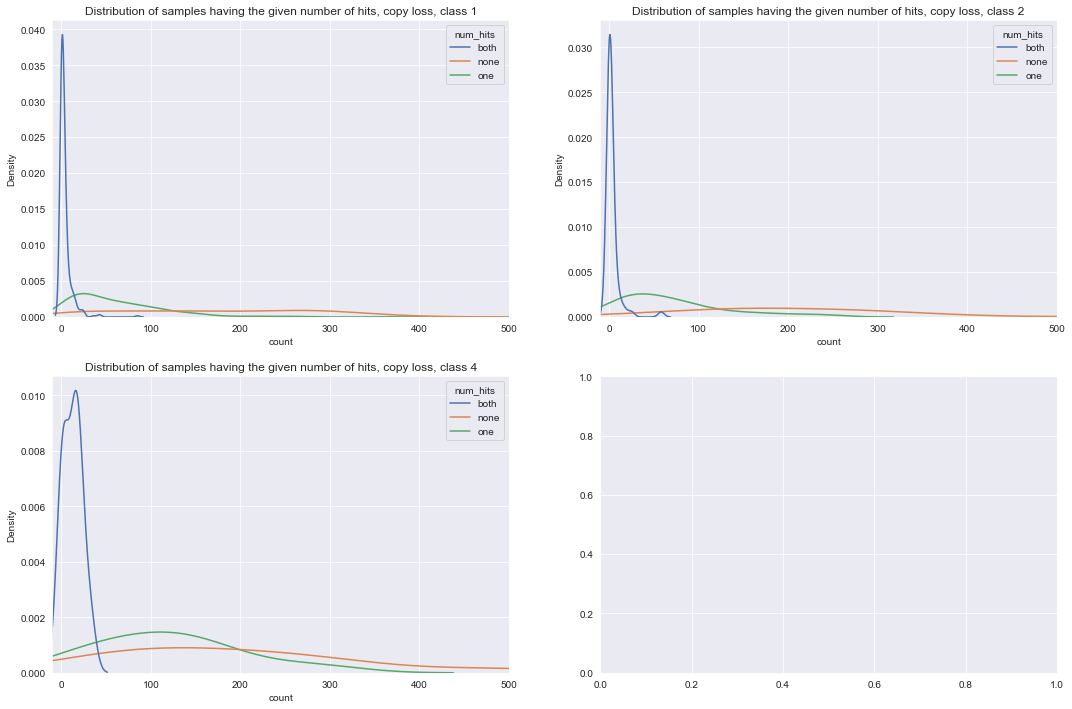

In [15]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot class counts distributions for copy loss
# we don't show class 3 genes here because they're defined based on
# copy gain (they are shown in the next plot)
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (class_counts_loss_df[class_counts_loss_df.class_name == class_name]
      .drop(columns='class_name')
      .dropna(axis='index')
      .reset_index()
      .rename(columns={'index': 'identifier'})
      .melt(id_vars='identifier', value_name='count', var_name='num_hits')
    )
    sns.kdeplot(data=plot_df, x='count', hue='num_hits', ax=ax)
    ax.set_title('Distribution of samples having the given number of hits, '
                 'copy loss, {}'.format(class_name))
    ax.set_xlim(-10, 500)

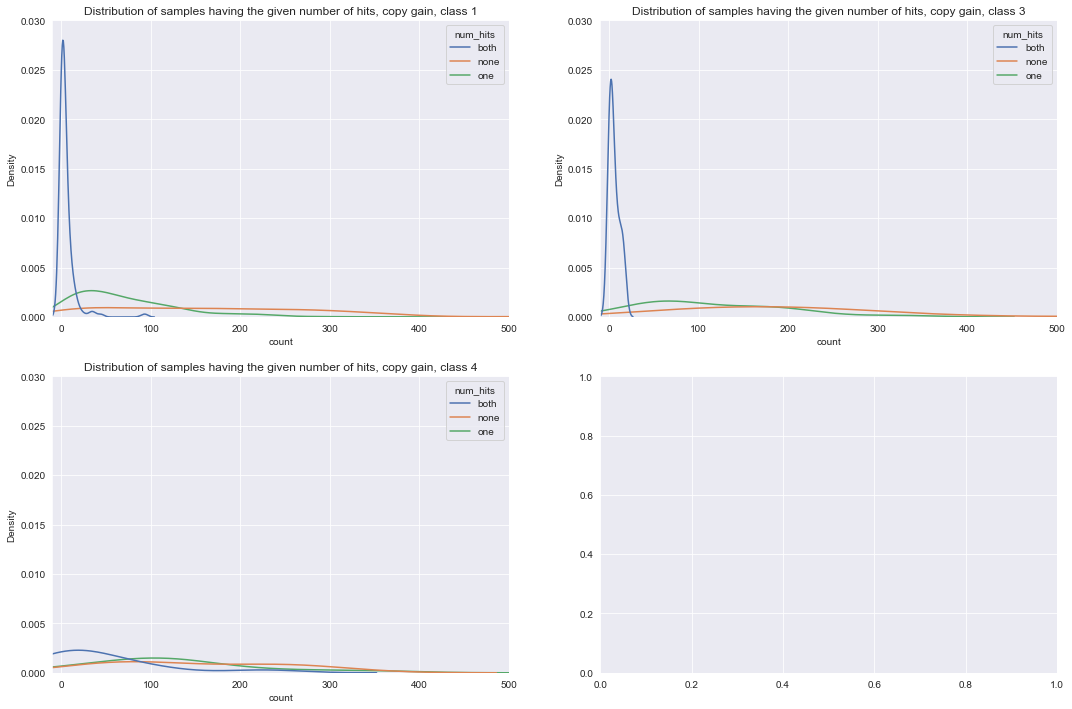

In [16]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot class counts distributions for copy gain
# we don't show class 2 genes here because they're defined based on
# copy loss (they were shown in the last plot)
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (class_counts_gain_df[class_counts_gain_df.class_name == class_name]
      .drop(columns='class_name')
      .dropna(axis='index')
      .reset_index()
      .rename(columns={'index': 'identifier'})
      .melt(id_vars='identifier', value_name='count', var_name='num_hits')
    )
    sns.kdeplot(data=plot_df, x='count', hue='num_hits', ax=ax)
    ax.set_title('Distribution of samples having the given number of hits, '
                 'copy gain, {}'.format(class_name))
    ax.set_xlim(-10, 500)
    ax.set_ylim(0.0, 0.03)

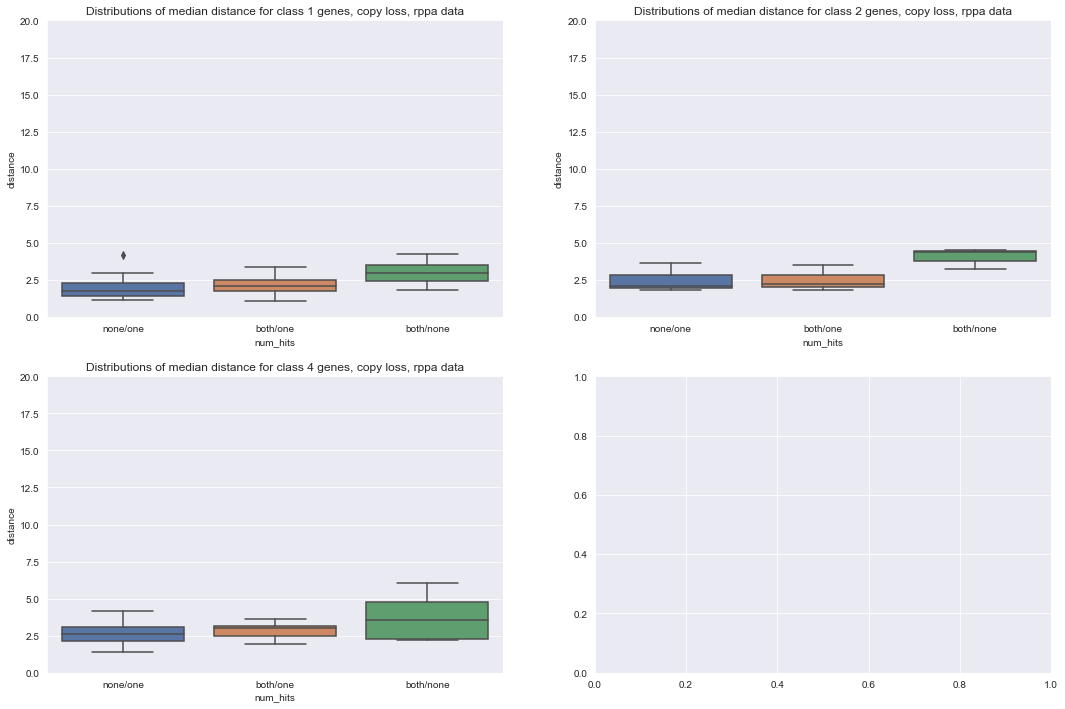

In [17]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_loss_df[results_loss_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    sns.boxplot(data=plot_df, x='num_hits', y='distance', ax=ax,
                order=['none/one', 'both/one', 'both/none'])
    if preprocessing == 'pca':
        if data_type == 'expression':
            ax.set_ylim(0, 180)
        elif data_type == 'rppa':
            ax.set_ylim(0, 20)
    elif data_type == 'rppa':
        ax.set_ylim(0, 15)
    elif data_type == 'expression':
        ax.set_ylim(0, 1.75e6)
    ax.set_title('Distributions of {} distance for {} genes, copy loss, {} data'.format(
                   centroid_method, class_name, data_type))

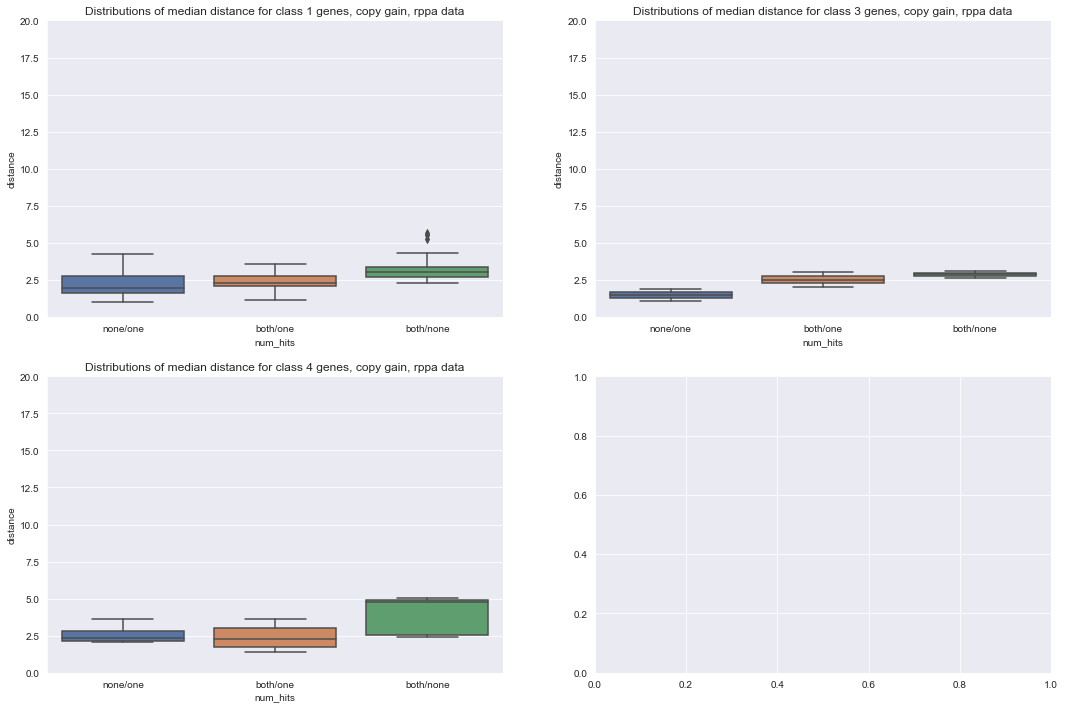

In [18]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot copy gain results here
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_gain_df[results_gain_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    sns.boxplot(data=plot_df, x='num_hits', y='distance', ax=ax,
                order=['none/one', 'both/one', 'both/none'])
    if preprocessing == 'pca':
        if data_type == 'expression':
            ax.set_ylim(0, 180)
        elif data_type == 'rppa':
            ax.set_ylim(0, 20)
    elif data_type == 'rppa':
        ax.set_ylim(0, 15)
    elif data_type == 'expression':
        ax.set_ylim(0, 1.75e6)
    ax.set_title('Distributions of {} distance for {} genes, copy gain, {} data'.format(
                   centroid_method, class_name, data_type))

See [these Google slides](https://docs.google.com/presentation/d/101FFx3vETEMgfeYUOmJSpF8TC69uVqx18vzk27lj6go/edit?usp=sharing) (particularly slide 2) for what we expected to see here. Over a few different parameter settings, and for raw and PCA-processed features, we don't really see what we expected to see. The none/one samples are almost always the closest together (not expected for class 1 genes), and one/both samples are generally quite far apart (again, not expected for class 1 genes), except for class 4 genes where one/both distance is comparable to none/one distance.

### Individual examples

Even though the overall results don't really meet our expectations, are there examples of genes/cancer types that do?

First, we'll look at genes that have greater "none/one" distance than "one/both" distance. This should indicate a "one-hit" gene; e.g. a single mutation or CNV "hit" changes the expression profile (gene expression or protein expression, for RNA-seq and RPPA data respectively) substantially.

In [19]:
one_hit_gain_df = results_gain_df[(results_gain_df['none/one'] > results_gain_df['both/one'])]
print(one_hit_gain_df.shape)
one_hit_gain_df.head(10)

(10, 4)


,both/none,both/one,none/one,class_name
APC_COADREAD,2.950653,1.146716,2.656007,class 1
BAP1_KIRC,5.242828,3.414805,4.247451,class 1
CDKN2A_HNSC,3.418984,2.044129,2.132973,class 1
CDKN2A_LUSC,2.346469,1.658510,1.725857,class 1
FUBP1_LGG,3.163028,1.549996,2.847589,class 1
RB1_SARC,5.542538,3.116832,3.763554,class 1
SETD2_KIRC,4.335664,2.121739,4.074378,class 1
TP53_BLCA,2.523794,1.386844,2.356105,class 4
TP53_HNSC,2.435854,1.713953,2.053642,class 4
TP53_UCEC,4.749338,2.285689,3.630120,class 4


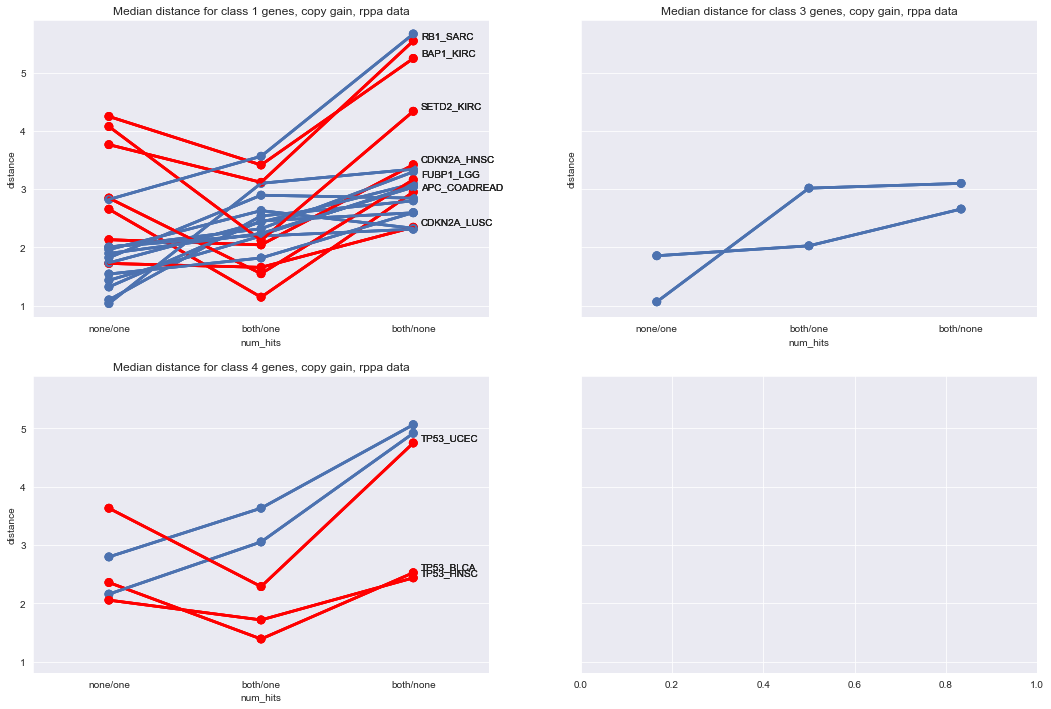

In [20]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2, sharey=True)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_gain_df[results_gain_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    for identifier in plot_df.identifier:
        if identifier in one_hit_gain_df.index:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', color='red', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
            eps = 0.05
            ax.annotate(
                identifier,
                (2+eps, plot_df.loc[(plot_df.identifier == identifier) &
                                    (plot_df.num_hits == 'both/none'), 'distance'].values[0]+eps)
            )
        else:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
        
    ax.set_title('{} distance for {} genes, copy gain, {} data'.format(
                   centroid_method.capitalize(), class_name, data_type))

In [21]:
one_hit_loss_df = results_loss_df[(results_loss_df['none/one'] > results_loss_df['both/one'])]
print(one_hit_loss_df.shape)
one_hit_loss_df.head(10)

(8, 4)


,both/none,both/one,none/one,class_name
APC_COADREAD,2.383777,1.854543,2.630734,class 1
PIK3CA_BLCA,2.604762,1.539602,1.935127,class 1
PIK3CA_CESC,4.039489,1.878735,2.998976,class 1
PIK3CA_HNSC,3.540798,1.973655,2.336395,class 1
PIK3CA_LUSC,4.229723,1.065126,4.152882,class 1
PPP2R1A_UCEC,4.863157,2.946038,3.079460,class 4
PTEN_UCEC,4.353624,1.817291,3.661465,class 2
TP53_BRCA,6.072463,3.064030,4.172397,class 4


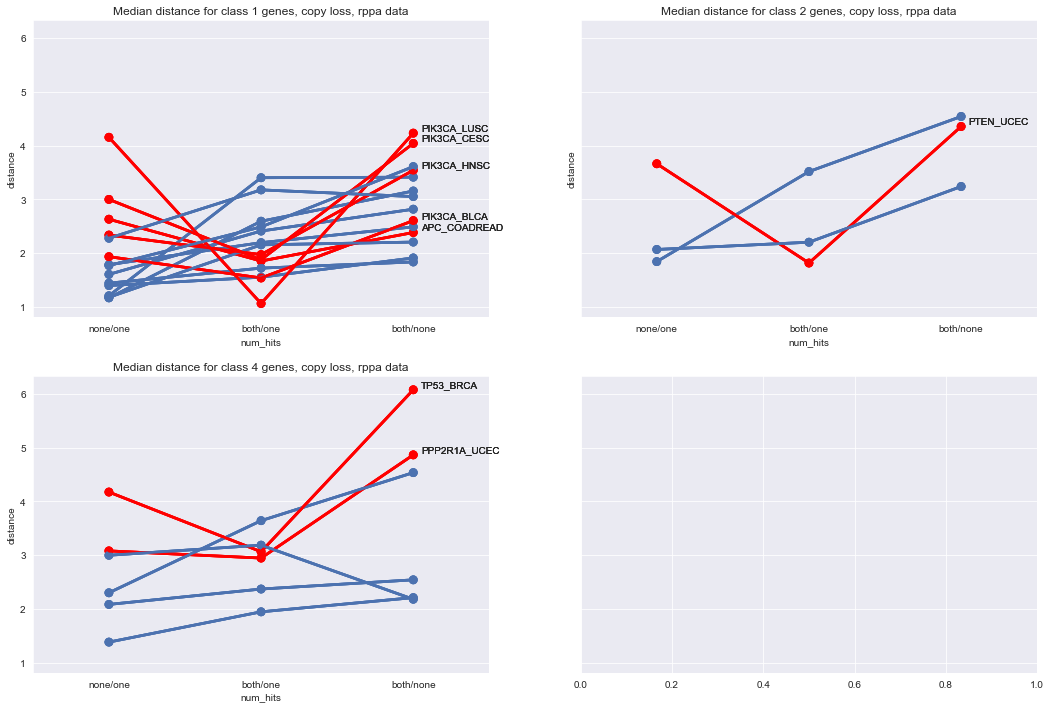

In [22]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2, sharey=True)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_loss_df[results_loss_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    for identifier in plot_df.identifier:
        if identifier in one_hit_loss_df.index:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', color='red', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
            eps = 0.05
            ax.annotate(
                identifier,
                (2+eps, plot_df.loc[(plot_df.identifier == identifier) &
                                    (plot_df.num_hits == 'both/none'), 'distance'].values[0]+eps)
            )
        else:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
    ax.set_title('{} distance for {} genes, copy loss, {} data'.format(
                   centroid_method.capitalize(), class_name, data_type))

Next, we can look at genes that have greater "one/both" distance than "none/one" distance. This should indicate a "two-hit" gene; e.g. a mutation in conjunction with a CNV "hit" changes the gene expression profile more substantially than either change alone.

In [23]:
two_hit_gain_df = results_gain_df[(results_gain_df['both/one'] > results_gain_df['none/one'])]
print(two_hit_gain_df.shape)
two_hit_gain_df.head(20)

(16, 4)


,both/none,both/one,none/one,class_name
ARID1A_BLCA,2.799850,2.540046,1.100248,class 1
ATRX_LGG,2.658793,2.028181,1.857673,class 3
CIC_LGG,3.296428,2.320818,2.002958,class 1
COL5A1_SKCM,2.329272,2.631703,1.963051,class 1
EP300_BLCA,3.092567,2.434356,1.735119,class 1
FAT1_HNSC,2.312581,2.195814,1.436534,class 1
FAT1_LUSC,2.846760,2.896021,1.824294,class 1
FBXW7_COADREAD,3.342535,3.100707,1.038232,class 1
KMT2C_BRCA,2.594518,2.456061,1.322539,class 1
KRAS_COADREAD,3.099080,3.017285,1.066967,class 3


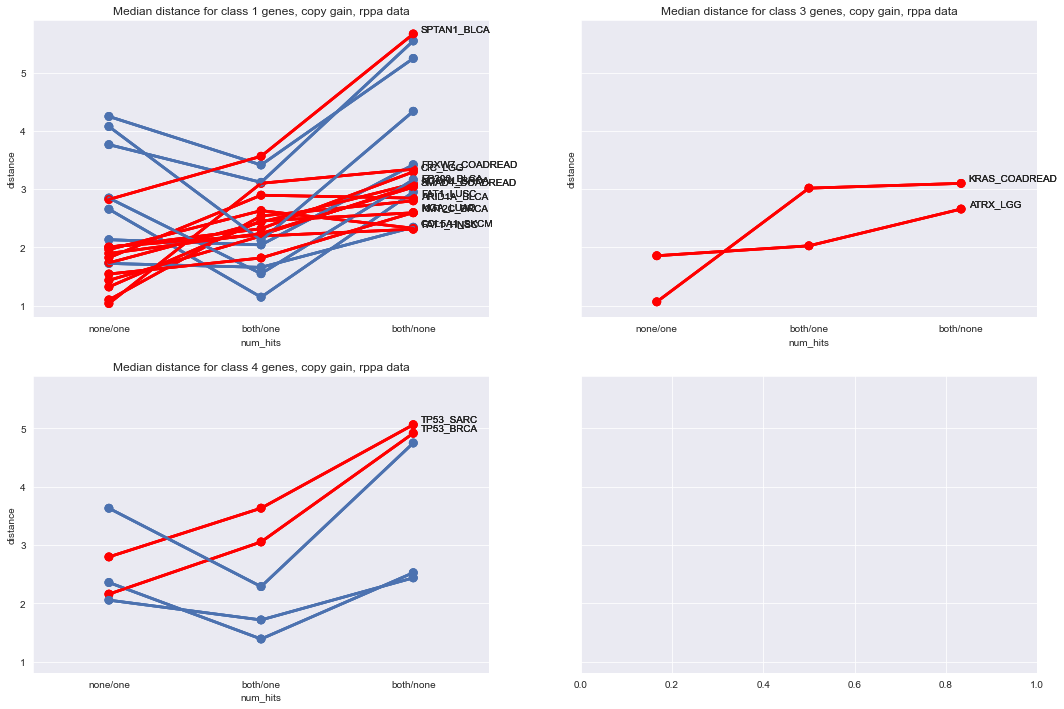

In [24]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2, sharey=True)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_gain_df[results_gain_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    for identifier in plot_df.identifier:
        if identifier in two_hit_gain_df.index:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', color='red', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
            eps = 0.05
            ax.annotate(
                identifier,
                (2+eps, plot_df.loc[(plot_df.identifier == identifier) &
                                    (plot_df.num_hits == 'both/none'), 'distance'].values[0]+eps)
            )
        else:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
        
    ax.set_title('{} distance for {} genes, copy gain, {} data'.format(
                   centroid_method.capitalize(), class_name, data_type))

In [25]:
two_hit_loss_df = results_loss_df[(results_loss_df['both/one'] > results_loss_df['none/one'])]
print(two_hit_loss_df.shape)
two_hit_loss_df.head(20)

(15, 4)


,both/none,both/one,none/one,class_name
ARID1A_BLCA,2.488626,2.195538,1.786653,class 1
KMT2C_BLCA,3.412207,3.401809,1.209002,class 1
KMT2D_BLCA,1.837048,1.722636,1.442928,class 1
KMT2D_LUSC,1.911781,1.554032,1.398855,class 1
KRAS_UCEC,2.816951,2.411393,1.606141,class 1
MAP3K1_BRCA,4.539107,3.516074,1.843382,class 2
NOTCH1_HNSC,3.155013,2.593357,1.170155,class 1
NRAS_SKCM,2.211174,1.947678,1.384963,class 4
PIK3CA_BRCA,2.206602,2.155145,1.181096,class 1
PIK3CA_STAD,3.052018,3.176045,2.277936,class 1


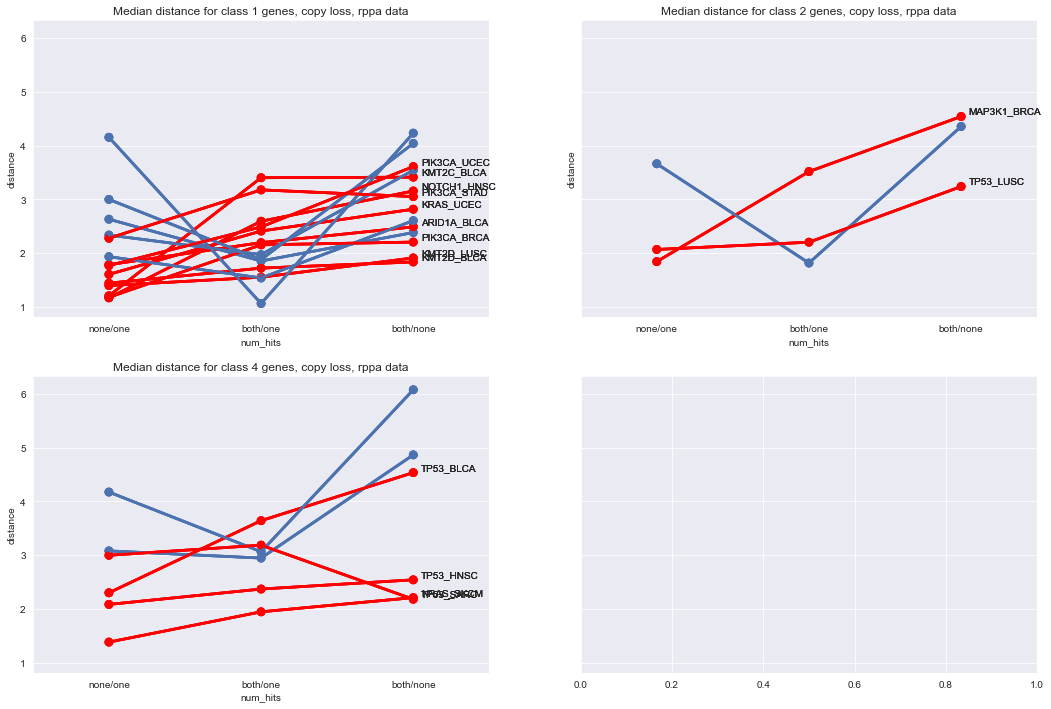

In [26]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2, sharey=True)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_loss_df[results_loss_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    for identifier in plot_df.identifier:
        if identifier in two_hit_loss_df.index:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', color='red', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
            eps = 0.05
            ax.annotate(
                identifier,
                (2+eps, plot_df.loc[(plot_df.identifier == identifier) &
                                    (plot_df.num_hits == 'both/none'), 'distance'].values[0]+eps)
            )
        else:
            sns.pointplot(data=plot_df[plot_df.identifier == identifier],
                          x='num_hits', y='distance', ax=ax,
                          order=['none/one', 'both/one', 'both/none'])
    ax.set_title('{} distance for {} genes, copy loss, {} data'.format(
                   centroid_method.capitalize(), class_name, data_type))